# State Autoencoder

This notebook trains a Transformer autoencoder to reconstruct measurements. It projects the sequential input down to a latent variable, $z$, that should represent the state of the system.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle
import data.datautil as du

from models import TransformerEncoder, TransformerDecoder

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading the data

In [3]:
data_name='Rectifier_oct23_cap'
sim_name='RectifierData_step10h' 
dataset_name='RUL_real_cap'

In [4]:
with open(f'./data/{data_name}/dataset_{dataset_name}_train.pkl', 'rb') as file:
    train_dataset = pickle.load(file)

In [5]:
with open(f'./data/{data_name}/dataset_{dataset_name}_test.pkl', 'rb') as file:
    test_dataset = pickle.load(file)

In [6]:
print(f'Dataset name: {train_dataset.dataset_name}') 
for var in train_dataset.n_var:
    if train_dataset.n_var[var]:
        print(f'Features ({var}): {train_dataset.labels[var]}')  
        print(f'-shape: {train_dataset.var[var].shape}')

if train_dataset.n_var['U']:
    simulation_size=train_dataset.origin['U'].shape[1]
    print(f'Simulation size: {simulation_size}') 
print(f'Number of systems: {train_dataset.n_sys}') 

Dataset name: RUL_real_cap
Features (X): ['i1', 'i2', 'i3', 'I_DC', 'C01', 'C02', 'C03']
-shape: (63179, 7)
Features (Y): ['RUL']
-shape: (63179, 1)
Number of systems: 200


In [7]:
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
trainloader = du.create_loader(train_dataset, batch_size, stats, window=window, shuffle=True)
trainloader

In [8]:
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
testloader = du.create_loader(test_dataset, batch_size, stats, window=window, shuffle=False)
testloader

In [9]:
ex_X, ex_y = next(iter(trainloader))
print(f"X Shape: {ex_X.shape}, Y Shape: {ex_y.shape}")

X Shape: torch.Size([128, 10, 7]), Y Shape: torch.Size([128, 1, 1])


In [10]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=2, dropout=0.1)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1)

In [11]:
pred = enc(ex_X.to(torch.float32))

In [12]:
xhat = dec(pred)

In [13]:
def plot_latent_space(enc, dataloader):
    zs = []
    enc.eval()
    for X, y in tqdm(dataloader):
        X = X.to(torch.float32).to(device)
        z = enc(X)
        zs.append(z.detach().cpu().numpy())
    
    zs = np.vstack(zs)
    print(zs.shape)
    plt.scatter(zs[:,0], zs[:,1])
    plt.show()
    
    return zs

100%|██████████| 480/480 [00:01<00:00, 405.18it/s]


(61379, 2)


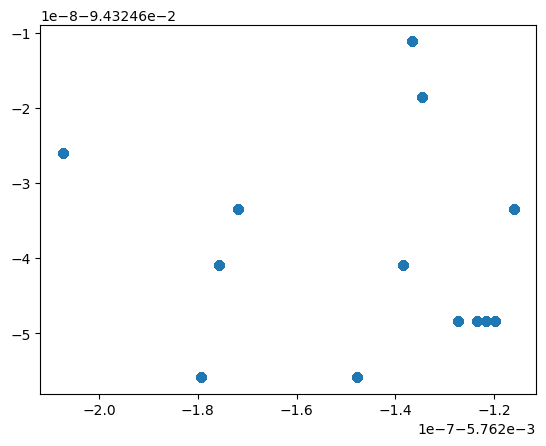

In [14]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=2, dropout=0.1, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=2, dropout=0.1).to(device)
zs = plot_latent_space(enc, trainloader)

In [15]:
enc = TransformerEncoder(input_dim=ex_X.shape[2], embed_dim=3, dropout=0.25, device=device).to(device)
dec = TransformerDecoder(output_dim=ex_X.shape[2], embed_dim=3, dropout=0.25).to(device)
objective = nn.MSELoss()
params = list(enc.parameters()) + list(dec.parameters())
    # optimizer
optim = torch.optim.Adam(params, lr=1e-4)

n_epochs = 10
losses = []
for i in tqdm(range(n_epochs)):
    for X, y in trainloader:
        optim.zero_grad()     
        X = X.to(torch.float32).to(device)
        y = y.to(device)
        
        z = enc(X)
        Xhat = dec(z)
        
        loss = objective(Xhat, X[:,-1,:])
        loss.backward()
        optim.step()
        
        losses.append(loss.item())
    # plot_latent_space(enc, trainloader)
    enc.train()
        
    print(f"Epoch: {i+1}, loss: {np.mean(losses[-100:])}")

 10%|█         | 1/10 [00:07<01:09,  7.76s/it]

Epoch: 1, loss: 0.03239025067538023


 20%|██        | 2/10 [00:15<01:01,  7.73s/it]

Epoch: 2, loss: 0.030714775640517472


 30%|███       | 3/10 [00:23<00:54,  7.74s/it]

Epoch: 3, loss: 0.02963637324050069


 40%|████      | 4/10 [00:30<00:46,  7.75s/it]

Epoch: 4, loss: 0.02850751843303442


 50%|█████     | 5/10 [00:38<00:38,  7.75s/it]

Epoch: 5, loss: 0.02660754952579737


 60%|██████    | 6/10 [00:46<00:30,  7.74s/it]

Epoch: 6, loss: 0.02205653501674533


 70%|███████   | 7/10 [00:54<00:23,  7.74s/it]

Epoch: 7, loss: 0.02136137871071696


 80%|████████  | 8/10 [01:01<00:15,  7.74s/it]

Epoch: 8, loss: 0.02042927423492074


 90%|█████████ | 9/10 [01:09<00:07,  7.74s/it]

Epoch: 9, loss: 0.020646582413464783


100%|██████████| 10/10 [01:17<00:00,  7.73s/it]

Epoch: 10, loss: 0.020349279921501876


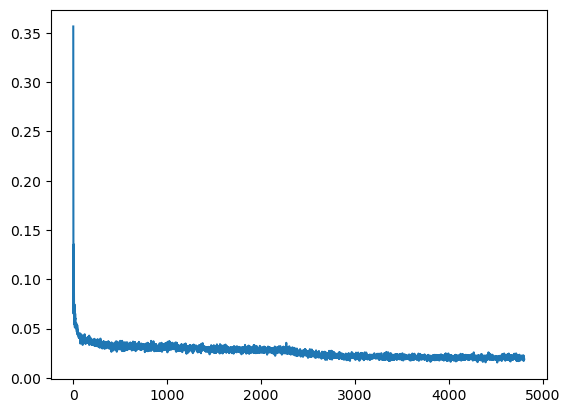

In [16]:
plt.plot(losses)

In [17]:
errors = []
zs = []
ruls = []
enc.eval()
dec.eval()
for X, y in tqdm(testloader):
    X = X.to(torch.float32).to(device)
    
    z = enc(X)
    Xhat = dec(z) 
    
    zs.append(z.detach().cpu().numpy())
    # print(Xhat.shape, X.shape)
    loss = objective(Xhat, X[:,-1,:])
    errors.append(loss.item())
    ruls.append(y.numpy())
    
ruls = np.concatenate(ruls).flatten()
zs = np.vstack(zs)
errors = np.array(errors)

100%|██████████| 122/122 [00:00<00:00, 429.81it/s]


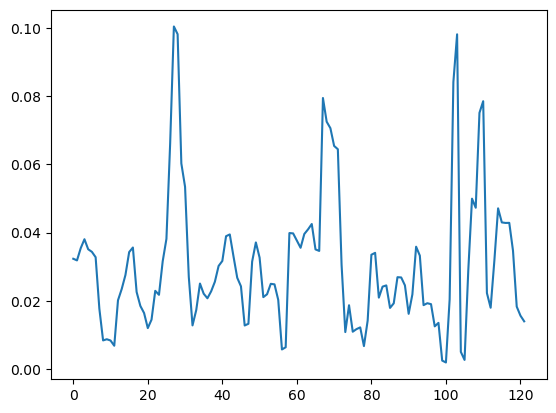

In [18]:
plt.plot(errors)

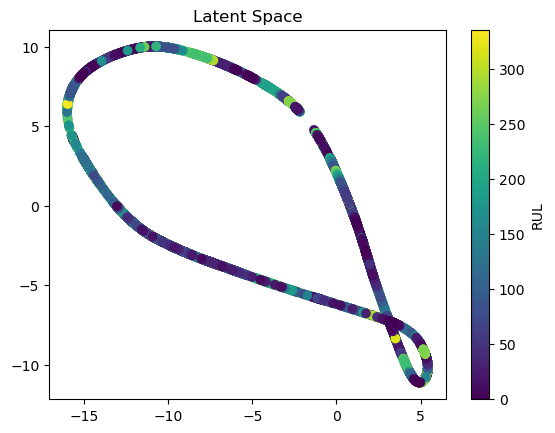

In [19]:
plt.title("Latent Space")
scatter = plt.scatter(zs[:,0], zs[:,1], c=ruls)
cbar = plt.colorbar(scatter)
cbar.set_label('RUL')  # Replace with an appropriate label

plt.show()

In [20]:
np.mean(errors)

0.03063356355939549

In [21]:
# torch.save({
#     'model_state_dict': enc.state_dict(),
#     'positional_embed': enc.positional_embed.data            
# }, './saved_models/const_enc_3dim.pth')
# torch.save(dec.state_dict(), './saved_models/const_dec_3dim.pth')

In [22]:
with open(f'./data/Rectifier_dic23_4steps_faults/dataset_RUL_real_train.pkl', 'rb') as file: # make sure this is the same dataset
    anomaly_dataset = pickle.load(file)
    
    
batch_size = 128
stats = ['X']
timestep=9
window={'X':[timestep,0],'Y':[0,0]}
anomalyloader = du.create_loader(anomaly_dataset, batch_size, stats, window=window, shuffle=False)
anomalyloader

In [46]:
next(iter(trainloader))

[tensor([[[0.2176, 0.2568, 0.2667,  ..., 0.9036, 0.9560, 0.9024],
          [0.4615, 0.5079, 0.5119,  ..., 0.9036, 0.9560, 0.9024],
          [0.5478, 0.5951, 0.5937,  ..., 0.9036, 0.9560, 0.9024],
          ...,
          [0.5249, 0.5762, 0.5809,  ..., 0.9036, 0.9560, 0.9024],
          [0.5532, 0.6039, 0.6066,  ..., 0.9036, 0.9560, 0.9024],
          [0.5187, 0.5723, 0.5800,  ..., 0.9036, 0.9560, 0.9024]],
 
         [[0.4693, 0.4919, 0.7979,  ..., 0.0552, 0.0536, 0.5645],
          [0.4988, 0.5197, 0.8233,  ..., 0.0552, 0.0536, 0.5645],
          [0.5041, 0.5234, 0.8320,  ..., 0.0552, 0.0536, 0.5645],
          ...,
          [0.4820, 0.5042, 0.8133,  ..., 0.0552, 0.0536, 0.5645],
          [0.4683, 0.4867, 0.7947,  ..., 0.0552, 0.0536, 0.5645],
          [0.4737, 0.4882, 0.8002,  ..., 0.0552, 0.0536, 0.5645]],
 
         [[0.5377, 0.8787, 0.7160,  ..., 0.2059, 0.7893, 0.4720],
          [0.5379, 0.8795, 0.7218,  ..., 0.2059, 0.7893, 0.4720],
          [0.5585, 0.9069, 0.7407,  ...,

In [50]:
def get_recons_errors(loader, encoder, decoder):
    encoder.eval()
    decoder.eval()
    recons_errors = []
    
    i = 0
    for X, y in loader:
        X = X.to(torch.float32).to(device)
        
        # if i == 1:
        #     X[:,-1,0] *= 5
        #     print(X.shape[0]*i)
        z = enc(X)
        
        Xhat = dec(z) 
        
        # recons = torch.mean(torch.square(Xhat - X[:,-1,:]), axis=1)
        recons = torch.square(Xhat - X[:,-1,:])
        
        # assert recons.shape[0] == X.shape[0]
        recons_errors.append(recons.detach().cpu().numpy())
        i += 1
        
    return np.concatenate(recons_errors)

In [51]:
train_recons = get_recons_errors(trainloader, enc, dec)
threshold = np.max(train_recons, axis=0)
threshold

array([0.11911321, 0.10551812, 0.10228892, 0.16075173, 0.19685817,
       0.47823828, 0.56025654], dtype=float32)

In [49]:
np.mean(train_recons, axis=0) + 2 * np.std(train_recons, axis=0)

array([0.55833715, 0.03669044, 0.03106594, 0.0567733 , 0.06101135,
       0.09685206, 0.17544264], dtype=float32)

In [76]:
def get_anom_recons_errors(loader, encoder, decoder):
    encoder.eval()
    decoder.eval()
    recons_errors = []
    
    i = 0
    for X, y in loader:
        X = X.to(torch.float32).to(device)
        
        if i == 1:
            X[:,-1,0] *= 1.5
            print(X.shape[0]*i)
        z = enc(X)
        
        Xhat = dec(z) 
        
        # recons = torch.mean(torch.square(Xhat - X[:,-1,:]), axis=1)
        recons = torch.square(Xhat - X[:,-1,:])
        
        # assert recons.shape[0] == X.shape[0]
        recons_errors.append(recons.detach().cpu().numpy())
        i += 1
        
    return np.concatenate(recons_errors)

In [77]:
anom_recons = get_anom_recons_errors(testloader, enc, dec)
# anomalies = anom_recons > (np.mean(train_recons, axis=0) + 5 * np.std(train_recons, axis=0)) # instead of max threshold, use this
anomalies = anom_recons > threshold # instead of max threshold, use this

anomalies = np.any(anomalies, axis=1).astype(np.float32)
anomalies


128


array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

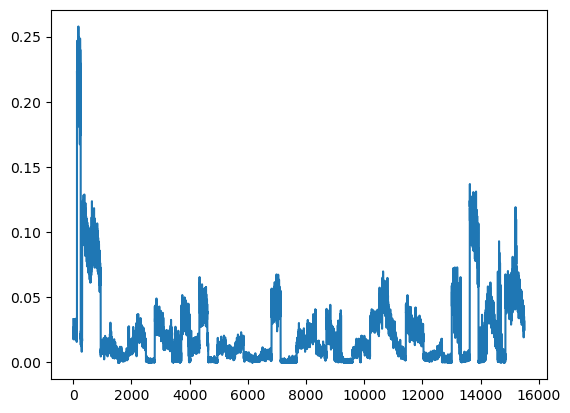

In [78]:
plt.plot(anom_recons[:,0])

In [79]:
ys = []
for X, y in anomalyloader:
    ys.append(y.detach().cpu().numpy().squeeze())

ys = np.concatenate(ys)

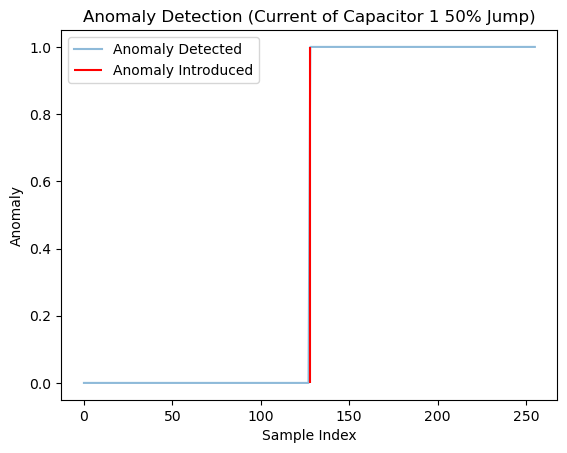

In [83]:
plt.title("Anomaly Detection (Current of Capacitor 1 50% Jump)")
plt.plot(anomalies[0:128*2], alpha=0.5, label='Anomaly Detected')
plt.vlines([128], ymin=0, ymax=1, color='red', label='Anomaly Introduced')
plt.ylabel("Anomaly")
plt.xlabel("Sample Index")
plt.legend()
# plt.plot(ys, alpha=0.5)